# Route Identification Over Time

Recent observations shows small chages in routes over time. Specifically in the following fields:
* route ID
* route short name
* route long name
* route desc

Need to observe these route changes in order to account for these changes in future analyses.

## Objective
1. Query data from `fct_monthly_routes` to help identify variences in Routes. Query for 2023, a couple of months. 
2. Save data to GCS `gtfs_schedule` bucket
3. Filter down data to `Sacramento Regional Transit`, identify and observe routes for any variences


## function from `open_data/download_vehicle_position.py`
    
    import datetime
    import gcsfs
    import geopandas as gpd
    import pandas as pd
    import shapely
    import sys

    from calitp_data_analysis.tables import tbls
    from calitp_data_analysis import utils
    from loguru import logger
    from siuba import *

    from shared_utils import schedule_rt_utils
    
    def download_vehicle_positions(
        date: str,
        operator_names: list
    ) -> pd.DataFrame:    
    
        df = (tbls.mart_gtfs.fct_vehicle_locations()
              >> filter(_.service_date == date)
              >> filter(_.gtfs_dataset_name.isin(operator_names))
              >> select(_.gtfs_dataset_key, _.gtfs_dataset_name,
                        _.schedule_gtfs_dataset_key,
                        _.trip_id, _.trip_instance_key,
                        _.location_timestamp,
                        _.location)
                  >> collect()
             )

In [1]:
#imports copied from download_vehicle_position.py script

import datetime
import gcsfs
import geopandas as gpd
import pandas as pd
import shapely
import sys

from calitp_data_analysis.tables import tbls
from calitp_data_analysis import utils
from loguru import logger
from siuba import *

from shared_utils import schedule_rt_utils
from shared_utils import geography_utils

/opt/conda/lib/python3.9/site-packages/google/auth/_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/opt/conda/lib/python3.9/site-packages/google/auth/_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/opt/conda/lib/python3.9/site-packages/google/auth/_default.py:78: UserWarning: Your application has authenticated using end user credentials from Googl

In [2]:
# test to query fct_monthly_routes
def get_monthly_routes(
        year: str,
        months: list
    ) -> pd.DataFrame:    
    
        df = (tbls.mart_gtfs.fct_monthly_routes()
              >> filter(_.year == year)
              >> filter(_.month.isin(months))
              >> select(_.key, _.source_record_id,
                        _.name,
                        _.route_id, _.shape_id,
                        _.month,
                        _.year,
                       _.pt_array)
                  >> collect()
             )
        return df

In [4]:
df = get_monthly_routes(2023, [4, 5, 6, 7, 8, 9])

In [9]:
df.shape

(24325, 8)

In [6]:
df.month.value_counts()

8    4254
6    4235
5    4180
9    4172
4    3848
7    3636
Name: month, dtype: int64

In [ ]:
#testing export to GCS > csuyat_folder

# 'gs://calitp-analytics-data/data-analyses/csuyat_folder/##FILENAME##.parquet'
# df.to_parquet()

#sucsessfully written to GCS, to csuyat_folder. need to export to gtfs_schedule folder 

#df.to_parquet('gs://calitp-analytics-data/data-analyses/csuyat_folder/route_identification_2023_m03_m05.parquet')

 make df to GPD 
<br>Query data from warehouse, then use this snippet from `make_routes_gdf` from `_shared_utils/shared_utils/geography_utils.py`.
* ddf["geometry"] = ddf.pt_array.apply(make_linestring)
    
<br> then save out as geo parquet to the `gtfs_schedule` folder in GCS (so versioning and history stays) using 
* utils.geoparquet_gcs_export(
                vp_gdf,
                SEGMENT_GCS,
                f"vp_{analysis_date}"
            )

In [8]:
#test of make_routes_gdf

aprl_sept_2023_routes = geography_utils.make_routes_gdf(df, "EPSG:4326")

In [24]:
display(type(aprl_sept_2023_routes))
display(aprl_sept_2023_routes.columns)
display(aprl_sept_2023_routes.geometry.name)

geopandas.geodataframe.GeoDataFrame

Index(['key', 'source_record_id', 'name', 'route_id', 'shape_id', 'month',
       'year', 'geometry'],
      dtype='object')

'geometry'

In [16]:
#writing to gcs bucket
aprl_sept_2023_routes.to_parquet('gs://calitp-analytics-data/data-analyses/gtfs_schedule/route_identification_2023_m04_m09.parquet')

In [ ]:
#test to writing line string

---

In [ ]:
#peaking into df to make sure everything looks good

#shape shows 11,927 rows and 8 columns
display(df.shape)

#type shows data is in df
display(type(df))

#columns return all the columns we listed in the function
display(list(df.columns))

#value_counts confirm df only has rows from 2023 March to May
display(df.value_counts(subset=['year','month']))

In [17]:
#creating sub-df for 'Sacramento Schedule'
#195 rows, 8 columns
sac = aprl_sept_2023_routes[aprl_sept_2023_routes['name'] == 'Sacramento Schedule']

In [23]:
#writing sac filtered gdf to gcs
sac.to_parquet('gs://calitp-analytics-data/data-analyses/gtfs_schedule/sac_route_identification_2023_m04_m09.parquet')

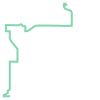

In [29]:
#test plot 
sac.geometry.iloc[2]


In [18]:
display(sac.shape)
display(sac.head(3))

(393, 8)

,key,source_record_id,name,route_id,shape_id,month,year,geometry
74,92ee64d95ea83c42a7922ae020226a66,recbzZQUIdMmFvm1r,Sacramento Schedule,213,45439,4,2023,"LINESTRING (-121.43869 38.52790, -121.43870 38..."
122,efb3865f306856498fc37d50203b2590,recbzZQUIdMmFvm1r,Sacramento Schedule,102,45972,8,2023,None
142,4def6187dada1c5406da712ebc6ffd53,recbzZQUIdMmFvm1r,Sacramento Schedule,019,45281,4,2023,"LINESTRING (-121.39221 38.71502, -121.39220 38..."


In [ ]:
sac_routes = sac['route_id'].unique()


In [ ]:
len(sac_routes)

## Next Steps

for every `name` and `route_id` in routes, need to see if each row is the same or not. Need to identify any variation in the routes. 



---

Trying to use a loop that will create a df for every route_id in sac_routes. but would need to do this for every `name` in the `fct_monthly_routes` df eventually?


In [ ]:
#empty dictionary
sac_sub_route_ids = {}

#each element in sac_routes will be called route.
#for each route in sac_routes, query each row related to that route.(where ever you use the variable route, go 1-by-1 the differnet
#then, create a dataframe for each route and place it into the dictionary sub_dataframes
for route in sac_routes:
    sub_df = sac[sac['route_id'] == route]
    sac_sub_route_ids[route] = sub_df

In [ ]:
len(sac_sub_route_ids)

In [ ]:
#testing dictionary with route 23 and 88
sac_sub_route_ids['023']

---

In [ ]:
#list of unique route names from initial df
route_names = df['name'].unique()


In [ ]:
#new loop that creates a dictionary of each unique schedule name with all its routes.
sub_route_name = {}

for name in route_names:
    sub_df2 = df[df['name'] == name]
    sub_route_name[name] = sub_df2
    

In [ ]:
#test to see if new dictionary works
sub_route_name['Auburn Schedule']

## Now I have `sac_sub_route_ids` and `sub_route_name` dictionaries

Examples of some noteable routes with slight variations over time.

In [ ]:
#General observations for Sacramento Schedule: 
#shape_id changes every month. 
#pt_array changes every month, however, did get a warning upon initial query of data so may need to review query to account for geodata
#Month 4 has the point geom data

display(sac_sub_route_ids['088'])
display(sac_sub_route_ids['023'])
display(sac_sub_route_ids['105'])
display(sac_sub_route_ids['F20'])
display(sac_sub_route_ids['215'])

In [ ]:
#test to see other route names
#other route names have more point geometry than Sacramento.
display(sub_route_name['Santa Cruz Schedule'])
display(sub_route_name['Merced Schedule'])
display(sub_route_name['San Diego Schedule'])
display(sub_route_name['Roseville Schedule'])

In [ ]:
import importlib

importlib.reload(segment_speed_utils)
from segment_speed_utils.project_vars import SCHED_GCS, analysis_date